# CSCI 3360 HW 3: Binary Logistic Regression
In this assignment, we will build and train a logistic regression model using a gradient descent algorithm. Here are some intructions you need to follow.

## Submission instruction
- Due by **<font color="red">11:59pm on Mar. 26th, 2018</font>**
- Complete this notebook and submit it by the due date
- Do not use any 3rd party libraries unless you are asked to do so.
- Feel free to define your own functions if needed.
- Do not hard-code any data-specific operations.

In this assignment, you will
- load a dataset from a csv file and preprocess it for a machine learning task,
- implement a function that computes the gradient of logistic regression model,
- train a logistic regression model without using the scikit-learn package, and
- plot training/test errors
- Total points: 110

First, let's import the required libraries.

In [2]:
a = [2,3]
a = sum(a)
print a

5


In [119]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt

We will use the **mushroom data set** in libsvm data repository. You can download the data from [here](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/mushrooms). The mushroom dataset contains 8124 examples and each example has <font color="red">112</font> features. The dataset is stored in **libsvm** format. 
The input dataset is just a text file, where 
- each line corresponds to an observation,
- each element is separated by a blank,
- it doesn't store features with zero values,
- the first element is a class label (a varaible to predict), and
- the rest elements has the format of "index:value".

As an example, let's consider the following two examples (with 5 features) in libsvm format.
> 1 2:1 3:1

> 2 1:1 5:1 

The first example's label is 1 ($Y_1 = 1$) and its feature vector is $X_1=(0, 1, 1, 0, 0)$, i.e., it has non-zero entries at indices 2 and 3. Likewise, $Y_2 = 2$ and $X_2=(1, 0, 0, 0, 1)$. Fortunately, since the libsvm format is frequently used in machine learning practice, the function to load libsvm file is already implemented in `sklearn` package. Check the documentation of `load_svmlight_file()` from [here](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_svmlight_file.html).

# Part 1. Preparing the Dataset

Download the data and store it in your local drive. The following code load the dataset into numpy arrays.

In [120]:
from sklearn.datasets import load_svmlight_file

X_sparse, y = load_svmlight_file('../Desktop/python/dataset/mushrooms.txt', n_features=112)

# converting sparse array into a dense one
X = np.zeros(X_sparse.shape)
X_sparse.toarray(out=X)
n, p = X.shape

print "X.shape=({}, {})".format(n, p)
print "len(y)=", len(y)
print "labels=", np.unique(y)
print len(y)
print X


X.shape=(8124, 112)
len(y)= 8124
labels= [ 1.  2.]
8124
[[ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


As we talked in class, we can remove the bias term from the equation by adding a dummy column to the input dataset. In practice, we don't actually need to materialize this dummy column, but in here we will add it to keep the things simple. After adding a dummy column, you dataset will look like:
$$ \mathbf{X} = 
\begin{pmatrix}
1 & x_{11} & x_{12} & \cdots & x_{1p} \\
1 & x_{21} & x_{22} & \cdots & x_{2p} \\
\vdots & \vdots & \vdots  & \ddots & \vdots \\
1 & x_{n1} & x_{n2} & \cdots & x_{np}
\end{pmatrix}
$$

### Q1. Augment the dataset by adding a dummy column of ones (5 pts).
(**Hint**: use np.ones() and [np.hstack()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.hstack.html))

In [121]:
######################################
#         Your code goes here        #
######################################
X = np.hstack((np.ones((8124,1)),X))
print X


[[ 1.  0.  0. ...,  0.  1.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]]


### Q2: Ensure that $Y \in \{-1, +1 \}$ (5 pts).
In simplified notation, it is assumed that $y_i \in \{-1, +1\}$. To satisf this assumption, we will **map <font color="red"> 1 to -1 and 2 to +1</font>**.

In [122]:
######################################
#         Your code goes here        #
######################################
for n in range(len(y)):
    if y[n] == 1.0:
        y[n] = -1
    elif y[n] == 2.0:
        y[n] = 1

print "labels=", np.unique(y)


# So, in here, we successfully changed the array.

labels= [-1.  1.]


We will use the 80% of examples for training and the remaining for testing.

In [123]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=1)



## Part 2. Logistic Regression

In class, we have seen that logistic regression model tries to learn the conditional probability using a sigmoid function:
$$ \Pr[Y = y_i~|~X=x_i] = \sigma(y_i\beta^\intercal x_i) \quad \text{ for }i=1, \ldots, n\,. $$

The maximum likelihood principle sugguests to minimize the following *empirical logistic loss*:
$$ \underset{\mathbf{\beta} \in \mathbb{R}^{p+1}}{\text{minimize}}\, \frac{1}{n}\sum_{i=1}^n \log (1 + \exp(-y_i\mathbf{\beta}^\intercal\mathbf{x}_i))\,, $$
and its gradient is given by
$$ \frac{\partial \ell(\mathbf{\beta})}{\partial \mathbf{\beta}} = \frac{1}{n}\sum_{i=1}^n (1 - \sigma(y_i\mathbf{\beta}^\intercal\mathbf{x}_i))y_i\mathbf{x}_i\,. $$
One simple but powerful method you can use to solve the above optimization problem is **<font color="red">gradient descent</font>** algorithm. Starting from an inital solution $\beta^{(0)}$, it iteratively computes the *gradient* at the given location $\beta^{(k)}$ and updates the solution as follows:
$$\beta^{(k+1)} = \beta^{(k)} - \eta \nabla f(\beta^{(k)})\,,$$
where
- $\beta^{(k)}$ denotes the parameter vector at iteration $k$,
- $\eta > 0$ is a constant step size, and 
- $\nabla f(\beta^{(k)})$ is the gradient of the objective function at $\beta^{(k)}$.


### Q3. Implement the objective function of logistic regression model (25 pts).
Given a numpy array $\beta$, the `logres_obj()` function should return 
$$ \frac{1}{n}\sum_{i=1}^n \log(1 + \exp(-y_i\beta^\intercal x_i))\,.$$

**<font color="red">Hint</font>**: let 
$$ W = \begin{pmatrix}
w_{11} & w_{12} & w_{13} \\
w_{21} & w_{22} & w_{23} \\
w_{31} & w_{32} & w_{33} \\
w_{41} & w_{42} & w_{43} 
\end{pmatrix} \in \mathbb{R}^{4\times 3}\,,\quad q = \begin{pmatrix}
q_1 \\ q_2 \\ q_3 \\ q_4 \end{pmatrix} \in \mathbb{R}^{4\times 1}\,, \quad \text{ and } \alpha = 
\begin{pmatrix}
\alpha_1 \\ \alpha_2 \\ \alpha_3 
\end{pmatrix} \in \mathbb{R}^{3 \times 1}.$$
Then, we can compute $\sum_{i=1}^4 \alpha^\intercal w_i = \sum_{i=1}^4 w_i^\intercal \alpha$ as follows:
$$
\sum_{i=1}^4 \alpha^\intercal w_i 
= \text{np.sum}\left\{W \alpha\right\}
= \text{np.sum}\left\{
\begin{pmatrix}
\alpha^\intercal w_1 \\
\alpha^\intercal w_2 \\
\alpha^\intercal w_3 \\
\alpha^\intercal w_4 
\end{pmatrix} \right\}\,,
$$
where $w_i = (w_{i1}, w_{i2}, w_{i3})$, i.e, the $i^\mathrm{th}$ row.

In [124]:
# ultimately, the value of y is the possibility of y. 
# So, when we injects a value inside the array, we will find out the value of y 

In [125]:
W = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])
alpha = np.array([1, 2, 3])
q = np.array([1, 2, 3, 4])

sum_wa = np.sum(np.dot(W, alpha), axis=0) 
print sum_wa

164


In [126]:
np.sum(np.array([1,2,3,4]))

10

If you want to compute $\sum_{i=1}^4 \log(\alpha^\intercal w_i)$, you can do 
$$
\sum_{i=1}^4 \log\alpha^\intercal w_i 
= \text{np.sum}\left\{\text{np.log}(W \alpha)\right\}
= \text{np.sum}\left\{
\begin{pmatrix}
\log \alpha^\intercal w_1 \\
\log\alpha^\intercal w_2 \\
\log\alpha^\intercal w_3 \\
\log\alpha^\intercal w_4 
\end{pmatrix}, axis=0 \right\}\,,$$

In [127]:
log_wa = np.log(np.dot(W, alpha))
print np.sum(log_wa, axis=0)

# In here, professor is giving us the log version of it.

14.236323943


$$\sum_{i=1}^4 w_i q_i = \text{np.sum}\left\{ 
\begin{pmatrix}
q_1 \cdot w_1 \\
q_2 \cdot w_2 \\
q_3 \cdot w_3 \\
q_4 \cdot w_4 
\end{pmatrix}, axis=0\right\}\,.$$ Refer to the lecture slides on <font color="red">numpy array broadcasting</font>.

In [128]:
# Try to understand the intention in here


print "q.shape=", q.shape # Initial shape in here.
q2d = np.atleast_2d(q) # View inputs as arrays with at least two dimensions. 
print "q2d.shape=", q2d.shape
q2d = q2d.T # it is used to transform our array 
print "what is T = {}".format(q2d)
print "(after transpose) q2d.shape=", q2d.shape


 

q.shape= (4,)
q2d.shape= (1, 4)
what is T = [[1]
 [2]
 [3]
 [4]]
(after transpose) q2d.shape= (4, 1)


$$ \frac{1}{n}\sum_{i=1}^n \log(1 + \exp(-y_i\beta^\intercal x_i))\,.$$

In [129]:
def logres_obj(X, y, beta):
    """
    returns the objective value of the logistic regression model
    
    Parameters:
    ------------
    X, y: numpy arrays representing the input dataset
    beta: numpy array correspoinding to the parameter vector
    Output:
    -------
    obj: objective value (scalar)
    """
    ######################################
    #         Your code goes here        #
    ######################################
    obj_result = 0
    for a in range(len(X)):
        scores = np.dot(beta.T,X[a] )
        obj = np.sum(np.log(1 + np.exp(-scores*y[a])))
        obj_result = obj_result + obj
    
    result = obj_result/n
    return result


In [140]:
beta = np.zeros(X.shape[1])
print logres_obj(X, y, beta)
beta = np.ones(X.shape[1])
print logres_obj(X, y, beta)



0.693232511987
10.6059337686


# Q4. Implement the function that returns the gradient of logistic regression model (35 pts).
The `logres_grad()` function should return
$$\frac{1}{n}\sum_{i=1}^n (\sigma(y_i\mathbf{\beta}^\intercal\mathbf{x}_i)-1)y_i\mathbf{x}_i \,.$$

Note that the output is a gradient (1D numpy array of length $p+1$). So the length of my array should have a length of 113 
- You should carefully distinguish vectors from scalars.
- Use the python's implementation of simoid function, `scipy.special.expit()` (check its documentation [here](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.special.expit.html))

In [132]:
import scipy
from scipy.special import expit
def logres_grad(X, y, beta):
    total = 0
    for a in range(len(X)):
        scores = np.dot(beta.T,X[a])
        sig = scores * y[a]
        sigmoid = scipy.special.expit(sig)
        result = (sigmoid - 1) * y[a] * X[a]
        total = total + result 
    return total/n 

### Q5. Gradient Descent Algorithm (20 points)
Using the two functions `logres_obj()` and `logres_grad()`, implement the gradient descent algorithm. The core of gradient descent algorithm is $$\beta^{(k+1)}=\beta^{(k)}-\eta\nabla f(\beta^{(k)})$$

1. Initialize the $\beta^{(0)} = (0, 0, \ldots, 0)^\intercal$.
2. Use the fixed step size $\eta=1.0$.

where
- $\beta^{(k)}$ denotes the parameter vector at iteration $k$,
- $\eta > 0$ is a constant step size, and 
- $\nabla f(\beta^{(k)})$ is the gradient of the objective function at $\beta^{(k)}$.

In [197]:


def grad_desc(X, y, n_iter):

    sol_path = []
    obj_vals = [] 
    eta = 1.0
    
    ############################
    #   your code goes here    #
    ############################
    b = np.zeros(X_new.shape[1])
    sol_path.append(b)
    
    for a in range(n_iter):
        sol_path.append(sol_path[a] - logres_grad(X, y, sol_path[a]))   
        obj_vals.append(logres_obj(X,y,sol_path[a]))
        
    return sol_path, obj_vals


  

## Prediction
Recall that in logistic regression we set 
$$ \Pr(Y=1~|~X=x) = \sigma(\mathbf{\beta}^\intercal\mathbf{x}). $$
Our prediction will be
$$
Y = \begin{cases}
1 & \mbox{ if $\Pr[Y=1~|~X=x] \geq 0.5$} \\
-1 & \mbox{ otherwise.}
\end{cases}
$$
Since the sigmoid function $\sigma(x)$ is greater than or equal to 0.5 when $x\geq 0$ (refer to the figure below), we will predict $Y=1$ when $\mathrm{sign}(\beta^\intercal x)$ is positive.  

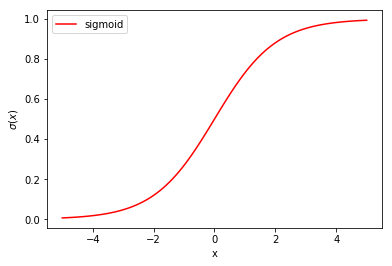

In [198]:
x = np.linspace(-5, 5, 100)
y_sig = expit(x)
fig, ax = plt.subplots()
ax.plot(x, y_sig, 'r-', label='sigmoid')
ax.set_xlabel('x')
ax.set_ylabel(r'$\sigma(x)$')
ax.legend()



### Q6. Implement a function that predicts the labels for the given examples (10 pts).

In [199]:
def sigmoid(X, y,beta):
    obj = []
    for a in range(len(X)):
        scores = np.dot(beta.T,X[a] )
        sig = scores * y[a]
        sigmoid = scipy.special.expit(sig)
        obj.append(sigmoid)
    return obj

        
def predict(X, beta):
    """
    predict the labels of observations in X
    
    Parameters:
    ----------------
    beta: coefficients
    X: 2D numpy array, a set of observations, an example per row
    
    Returns:
    y_hat: predicted labels    
    """
    
    ############################
    #   your code goes here    #
    ############################
    # The idea is when the user inputs X and beta, the function should return the predicted value to the user
    '''''Predict label using learned logistic regression parameters'''  
    h = sigmoid(X, y, beta) # I defined a sigmoid function above
    answer = []
    for a in range(len(h)):
        if h[a]>0.5:
            answer.append(1)
        elif h[a] <= 0.5:
            answer.append(0)
               
    y_hat = answer
    
    
   
    return y_hat

## Training

Now we're ready to train the logistic regression model using our implementation of gradient descent.

In [201]:
n_iter = 500
sols, objs = grad_desc(X_train, y_train, n_iter=n_iter)


We have 500 elements in the array `sols`, and each element is an estimate of $\beta$ (or solution) at iteration $k$. We can expect that the accuracy of $\beta$ improves as $k$ increases.

### Q7. Draw a plot that shows how the objective values change as we do more gradient descent updates (5 pts).
In other words, x-axis = iteration number $k$ and y-axis = objective value at iteration $k$.

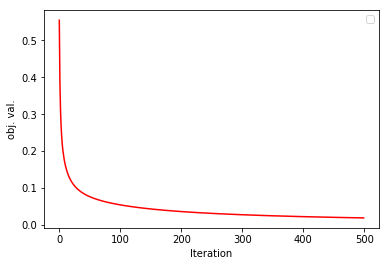

In [209]:
############################
#   your code goes here    #
############################
x = np.array(range(n_iter))
y_line = objs
fig, ax = plt.subplots()
ax.plot(x, y_line, 'r-')
ax.set_xlabel('Iteration')
ax.set_ylabel('obj. val.')
ax.legend()



### Q8. Using the function `predict()` and estimates in `sols`, compute training and test errors (5 pts). 
- use 'red'solid line and 'blue' dotted line for training and testing, respectively.
- set the figsize=(10, 6.5)

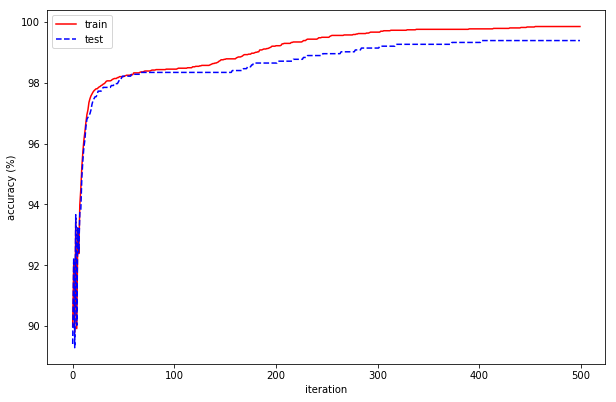

In [27]:
def compute_accuracy(testX, testY, sols):
    """
    returns the accuracy of each solution on the given dataset
    
    accuracy = percentage of correctly classified examples
    
    Parameters
    -----------
    testX, testY: input dataset
    sols: a list of parameter vectors
    
    Returns
    --------
    acc: a list of accuracies, each element corresponds to the accuracy of each solution in sols
    """
    acc = []
    
    n_examples = len(testY)
    
    for sol in sols:  
        pred = predict(testX, sol)
        n_correct = n_examples - np.count_nonzero(testY - pred)
        acc.append((n_correct*100.0)/n_examples)
        
    return acc

train_accs = compute_accuracy(X_train, y_train, sols)
test_accs = compute_accuracy(X_test, y_test, sols)

# plot the training/test errors against iterations
# you need to have two series (or lines) in a single plot

##########################
#   Your code goes here  #
##########################
